### Import Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.feature_selection import RFECV

### See if it's clean

In [2]:
유방암=pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
유방암=유방암.dropna(axis=1,how="all")
print(유방암.shape,유방암.shape[0]*유방암.shape[1])
유방암.info()

(569, 32) 18208
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_

### Preprocessing i: Slice Data

In [3]:
yba=유방암.copy()
ybaIndex=yba.iloc[:,0]
ybaY=yba.iloc[:,1]
ybaX=yba.iloc[:,2:]

### Preprocessing ii: Standardization & Normalization

In [4]:
yeoJohnson=PowerTransformer()
ybaX=pd.DataFrame(yeoJohnson.fit_transform(ybaX),columns=ybaX.columns)
ybaX.agg(["mean","median"]).filter(regex="mean$").round(5)

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
mean,0.0000,0.00000,-0.00000,0.0000,-0.0000,0.00000,-0.00000,0.00000,-0.00000,-0.00000
median,-0.0564,0.00083,-0.07175,-0.0566,0.0294,-0.03392,-0.13618,-0.23281,0.02629,-0.02013


### Preprocessing iii: RFECV: Feature Reduction

In [5]:
minFeatureCount=3
estimator=LogisticRegression()
kfold=StratifiedKFold(
    n_splits=16,
    shuffle=True,
    random_state=23301522
)
rfecv=RFECV(
    estimator=estimator,
    scoring="accuracy",
    min_features_to_select=minFeatureCount,
    n_jobs=-1
)
rfecv.fit(ybaX,ybaY)
rfeScoreCount=len(rfecv.cv_results_["mean_test_score"])

<ErrorbarContainer object of 3 artists>

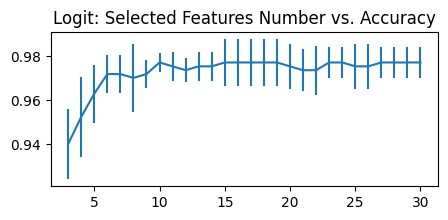

In [6]:
plt.figure(figsize=(5,2))
plt.title("Logit: Selected Features Number vs. Accuracy")
plt.errorbar(
    range(minFeatureCount, minFeatureCount + rfeScoreCount),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"]
)

In [7]:
ybaHelpfulFeature=rfecv.feature_names_in_[rfecv.support_]
print(f"Optimal Features Count: {len(ybaHelpfulFeature)}")
ybaY_=ybaY.copy()# .replace({"B":0,"M":1})
ybaX_=ybaX.copy()[ybaHelpfulFeature]

Optimal Features Count: 10


### Modeling i: Get an Alpha

In [8]:
alphas=np.logspace(-3,5,100)
perAlphaResult=[]
for alpha in alphas:
    _cv=cross_validate(
        RidgeClassifier(alpha),
        ybaX_,
        ybaY_,
        scoring="accuracy",
        cv=kfold,
        return_estimator=True,
        n_jobs=-1
    )
    _cvCoef=[estimator.coef_ for estimator in _cv["estimator"]]
    _cvCoefMean=np.mean(_cvCoef,axis=0)
    _cvScoreMean=np.mean(_cv["test_score"])
    perAlphaResult.append((
        np.array([alpha]),
        np.array([_cvScoreMean]),
        _cvCoefMean[0]
    ))
    del _cv["estimator"]

Text(0.5, 1.0, 'Per-alpha Accuracy')

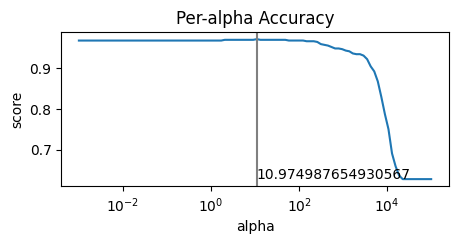

In [9]:
perAlphaDataFrameColumn=["alpha","score"]
perAlphaDataFrameColumn.extend(ybaX_.columns)
perAlphaResultDataFrame=pd.DataFrame(
    [np.concatenate(q) for q in perAlphaResult],
    columns=perAlphaDataFrameColumn
)
perAlphaBestScore=perAlphaResultDataFrame.alpha[perAlphaResultDataFrame.score.idxmax()]
plt.figure(figsize=(5,2))
_p=sns.lineplot(
    x=perAlphaResultDataFrame.alpha,
    y=perAlphaResultDataFrame.score
)
_p.set_xscale("log")
_p.axvline(
    x=perAlphaBestScore,
    color=".5"
)
_p.text(
    x=perAlphaBestScore,
    y=perAlphaResultDataFrame.score.min(),
    s=f"{perAlphaBestScore}"
)
_p.set_title("Per-alpha Accuracy")

### Modeling ii: Model

In [10]:
ridge=RidgeClassifier(perAlphaBestScore)
ridge.fit(ybaX_,ybaY_)

RidgeClassifier(alpha=10.974987654930567)